## Data Preparation and EDA

### Download dataset and import libraries

In [24]:
# !pip install opendatasets

# import opendatasets as od
# username = normanlapid
# API_key = c153837540a86c2d226f5d2967a55f55
# od.download("https://www.kaggle.com/rdizzl3/jpeg-happywhale-384x384")

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import random
import gc

import warnings
warnings.filterwarnings('ignore')

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [27]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.6.0


In [28]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)


seed_everything(143) 

### Data cleaning and EDA

In [29]:
df_train = pd.read_csv('jpeg-happywhale-384x384/train.csv')

In [30]:
df_train['species'].value_counts().sort_index()

beluga                       7443
blue_whale                   4830
bottlenose_dolphin           9664
bottlenose_dolpin            1117
brydes_whale                  154
commersons_dolphin             90
common_dolphin                347
cuviers_beaked_whale          341
dusky_dolphin                3139
false_killer_whale           3326
fin_whale                    1324
frasiers_dolphin               14
globis                        116
gray_whale                   1123
humpback_whale               7392
kiler_whale                   962
killer_whale                 1493
long_finned_pilot_whale       238
melon_headed_whale           1689
minke_whale                  1608
pantropic_spotted_dolphin     145
pilot_whale                   262
pygmy_killer_whale             76
rough_toothed_dolphin          60
sei_whale                     428
short_finned_pilot_whale      367
southern_right_whale          866
spinner_dolphin              1700
spotted_dolphin               490
white_sided_do

In [31]:
df_train['species'].replace({"globis": "short_finned_pilot_whale",
                             "pilot_whale": "short_finned_pilot_whale",
                             "kiler_whale": "killer_whale",
                             "bottlenose_dolpin": "bottlenose_dolphin"},
                            inplace=True)

In [32]:
df_train.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


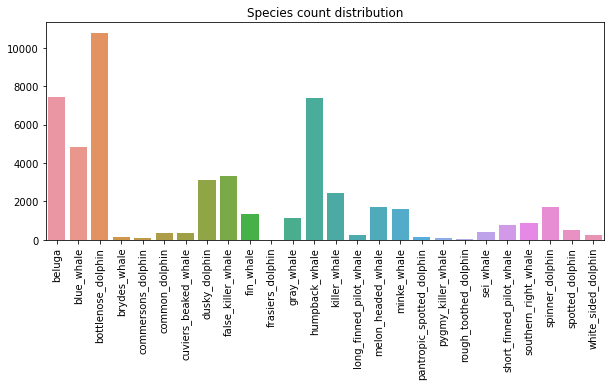

In [33]:
train_val_count = df_train['species'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 4))

chart = sns.barplot(x=train_val_count.index, y=train_val_count.values, ax=ax)
ax.set_title('Species count distribution')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [34]:
train_ind_count = df_train.groupby('species')['individual_id'].nunique()
train_ind_count

species
beluga                       1012
blue_whale                   2348
bottlenose_dolphin            904
brydes_whale                   44
commersons_dolphin             70
common_dolphin                 38
cuviers_beaked_whale          183
dusky_dolphin                2731
false_killer_whale            196
fin_whale                     466
frasiers_dolphin               13
gray_whale                    185
humpback_whale               2679
killer_whale                  472
long_finned_pilot_whale       131
melon_headed_whale           1323
minke_whale                   128
pantropic_spotted_dolphin      44
pygmy_killer_whale             24
rough_toothed_dolphin          46
sei_whale                     197
short_finned_pilot_whale      458
southern_right_whale          549
spinner_dolphin               891
spotted_dolphin               280
white_sided_dolphin           175
Name: individual_id, dtype: int64

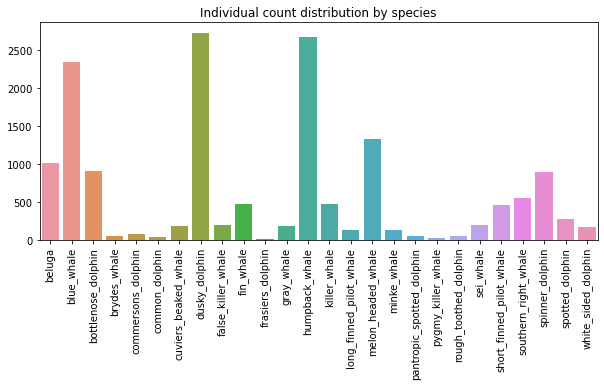

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

chart = sns.barplot(x=train_ind_count.index, y=train_ind_count.values, ax=ax)
ax.set_xlabel(None)
ax.set_title('Individual count distribution by species')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Parameters

In [36]:
work_dir = "./jpeg-happywhale-384x384"
save_dir = "./savefiles"
train_folder = "train_images"
test_folder = "test_images"
img_col = "image"
label_col = "individual_id"
specie_col = "species"

target_col = specie_col
num_classes = len(df_train[target_col].value_counts())

In [37]:
# print(os.listdir(WORK_DIR))
print('Train images: %d' %len(os.listdir(
    os.path.join(work_dir, train_folder))))
print('Test images: %d' %len(os.listdir(
    os.path.join(work_dir, test_folder))))

Train images: 51033
Test images: 27956


In [38]:
specie_names = df_train['species'].value_counts().index
specie_idx_map = {specie: idx for idx, specie in enumerate(specie_names)}
idx_specie_map = {idx: specie for specie, idx in specie_idx_map.items()}

In [39]:
label_names = df_train['individual_id'].value_counts().index
label_idx_map = {label: idx for idx, label in enumerate(label_names)}
idx_label_map = {idx: label for label, idx in label_idx_map.items()}

In [40]:
df_train["species_idx"] = df_train['species'].map(specie_idx_map)
df_train["individual_idx"] = df_train['individual_id'].map(label_idx_map)

In [41]:
df_train.head()

,image,species,individual_id,species_idx,individual_idx
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,8,9709
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,2,3369
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,4,71
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,0,67
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,2,111


In [42]:
batch_size = 64
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size
epochs = 4
target_size = 256

## Model Architecture Comparison

### Baseline CNN Model

#### Data augmentation and prepare data generators

In [18]:
# Training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   preprocessing_function=None,
                                   rotation_range=45,
                                   zoom_range=0.2,
                                   brightness_range=[0.6, 1.4],
                                   channel_shift_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   shear_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1)

train_generator = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

val_generator = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### Training

In [19]:
tf.keras.backend.clear_session()

In [20]:
base_cnn = models.Sequential()

base_cnn.add(layers.Conv2D(filters=32, kernel_size=6, strides=1, padding='same',
                 input_shape=(target_size, target_size, 3)))
base_cnn.add(layers.BatchNormalization(axis=3))
base_cnn.add(layers.Activation('relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

base_cnn.add(layers.Conv2D(filters=64, kernel_size=3, strides=1,  padding='same',
                        activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(3, 3)))

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(256, activation="relu"))
base_cnn.add(layers.Dropout(0.6))

base_cnn.add(layers.Dense(num_classes, activation='softmax'))
base_cnn.summary()

base_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 112896)            0

In [21]:
%%time

filepath_cnn = save_dir + "/base_cnn_wts.hdf5"
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

base_cnn_history = base_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cnn]
)


Epoch 1/4
637/637 [==============================] - 1039s 2s/step - loss: 2.6146 - accuracy: 0.3360 - val_loss: 2.0659 - val_accuracy: 0.3733

Epoch 00001: val_accuracy improved from -inf to 0.37331, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1174s 2s/step - loss: 1.9758 - accuracy: 0.4090 - val_loss: 1.6577 - val_accuracy: 0.4988

Epoch 00002: val_accuracy improved from 0.37331 to 0.49882, saving model to ./savefiles/base_cnn_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1042s 2s/step - loss: 1.8576 - accuracy: 0.4440 - val_loss: 1.7097 - val_accuracy: 0.4728

Epoch 00003: val_accuracy did not improve from 0.49882
Epoch 4/4
637/637 [==============================] - 1033s 2s/step - loss: 1.7764 - accuracy: 0.4661 - val_loss: 1.7056 - val_accuracy: 0.4897

Epoch 00004: val_accuracy did not improve from 0.49882
CPU times: user 1h 5min 48s, sys: 4min 40s, total: 1h 10min 29s
Wall time: 1h 11min 32s


In [22]:
base_cnn.load_weights(filepath_cnn)

base_cnn.save(save_dir + '/baseline_cnn.h5')

import pickle
with open(save_dir + '/baseline_cnn_hist.pickle', 'wb') as handle:
    pickle.dump(base_cnn_history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

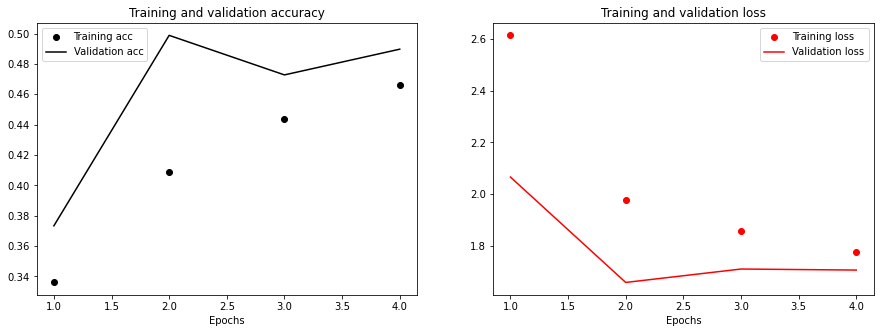

In [24]:
plot_results(base_cnn_history)

### Transfer Learning with Inception V3

In [25]:
tf.keras.backend.clear_session()

#### Data augmentation and prepare data generators

In [26]:
# Training set
unscaled_train_datagen = ImageDataGenerator(validation_split=0.2,
                                            preprocessing_function=None,
                                            rotation_range=45,
                                            zoom_range=0.2,
                                            brightness_range=[0.6, 1.4],
                                            channel_shift_range=0.7,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='nearest',
                                            shear_range=0.1,
                                            height_shift_range=0.1,
                                            width_shift_range=0.1)

unscaled_train_gen = (
    unscaled_train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
unscaled_val_datagen = ImageDataGenerator(validation_split=0.2)

unscaled_val_gen = (
    unscaled_val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(target_size, target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### Train only top layer

In [30]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = "imagenet")

inception_v3.trainable = False

model_inv3 = models.Sequential()
model_inv3.add(layers.Lambda(preprocess_inception_v3,
                             input_shape=(target_size, target_size, 3)))
model_inv3.add(inception_v3)
model_inv3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3.add(layers.Flatten())
model_inv3.add(layers.Dense(256, activation="relu"))
model_inv3.add(layers.Dropout(0.6))
model_inv3.add(layers.Dense(num_classes, activation='softmax'))

model_inv3.summary()

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)               

In [31]:
%%time

filepath_inv = save_dir + "/model_inv3_wts.hdf5"
checkpoint_inv = ModelCheckpoint(filepath_inv, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_inv3 = model_inv3.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv]
)

Epoch 1/4
637/637 [==============================] - 1030s 2s/step - loss: 2.4698 - accuracy: 0.3551 - val_loss: 1.5864 - val_accuracy: 0.5924

Epoch 00001: val_accuracy improved from -inf to 0.59240, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1095s 2s/step - loss: 2.0638 - accuracy: 0.4125 - val_loss: 1.4963 - val_accuracy: 0.6027

Epoch 00002: val_accuracy improved from 0.59240 to 0.60268, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 3/4
637/637 [==============================] - 973s 2s/step - loss: 1.9837 - accuracy: 0.4208 - val_loss: 1.4773 - val_accuracy: 0.6069

Epoch 00003: val_accuracy improved from 0.60268 to 0.60690, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 4/4
637/637 [==============================] - 954s 1s/step - loss: 1.9331 - accuracy: 0.4287 - val_loss: 1.5438 - val_accuracy: 0.5668

Epoch 00004: val_accuracy did not improve from 0.60690
CPU times: user 1h 2min 59s, sys: 4min 35s, total:

In [32]:
model_inv3.load_weights(filepath_inv)

model_inv3.save(save_dir + '/inception_v3.h5')

with open(save_dir + '/inception_v3_hist.pickle', 'wb') as handle:
    pickle.dump(history_inv3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Unfreeze part of base model and retrain

In [33]:
inception_v3.trainable = True

for layer in inception_v3.layers[:249]:
    layer.trainable = False
for layer in inception_v3.layers[249:]:
    layer.trainable = True

model_inv3.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['accuracy'])

model_inv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)               

In [34]:
%%time


history_inv3 = model_inv3.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv]
)

Epoch 1/4
637/637 [==============================] - 976s 2s/step - loss: 1.7348 - accuracy: 0.5151 - val_loss: 1.2227 - val_accuracy: 0.6329

Epoch 00001: val_accuracy improved from 0.60690 to 0.63286, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 2/4
637/637 [==============================] - 983s 2s/step - loss: 1.4975 - accuracy: 0.5684 - val_loss: 1.0872 - val_accuracy: 0.6672

Epoch 00002: val_accuracy improved from 0.63286 to 0.66716, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 3/4
637/637 [==============================] - 959s 2s/step - loss: 1.3855 - accuracy: 0.5954 - val_loss: 0.9946 - val_accuracy: 0.6835

Epoch 00003: val_accuracy improved from 0.66716 to 0.68352, saving model to ./savefiles/model_inv3_wts.hdf5
Epoch 4/4
637/637 [==============================] - 955s 1s/step - loss: 1.2462 - accuracy: 0.6311 - val_loss: 0.8025 - val_accuracy: 0.7600

Epoch 00004: val_accuracy improved from 0.68352 to 0.76004, saving model to ./savefiles/model_inv3_wts.h

In [35]:
model_inv3.load_weights(filepath_inv)

model_inv3.save(save_dir + '/inception_v3_ft.h5')

with open(save_dir + '/inception_v3_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_inv3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

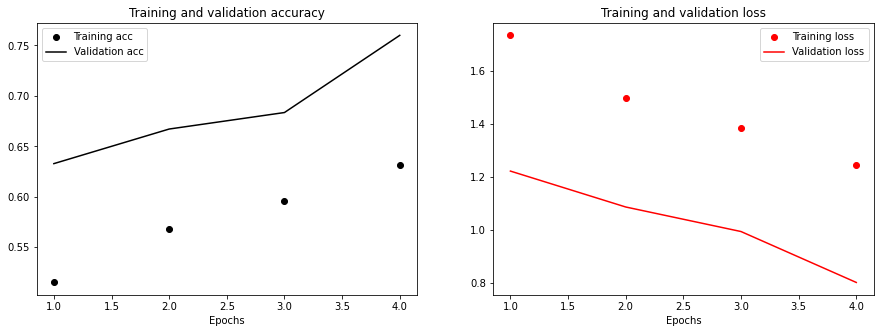

In [36]:
plot_results(history_inv3)

### Transfer Learning with VGG16 + Fine-Tuning

In [39]:
tf.keras.backend.clear_session()

#### Train only top layer

In [40]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False)

vgg16.trainable = False

model_vgg16 = models.Sequential()
model_vgg16.add(layers.Lambda(preprocess_vgg16,
                             input_shape=(target_size, target_size, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation="relu"))
model_vgg16.add(layers.Dropout(0.6))
model_vgg16.add(layers.Dense(num_classes, activation='softmax'))

model_vgg16.summary()

model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 23,110,234
Trainable params: 8,395,546
Non-trainable params: 14,714,688
____________________________________

In [41]:
%%time

filepath_vgg = save_dir + "/model_vgg16_wts.hdf5"
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_vgg16 = model_vgg16.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_vgg]
)

Epoch 1/4
637/637 [==============================] - 1196s 2s/step - loss: 2.9621 - accuracy: 0.3615 - val_loss: 1.7824 - val_accuracy: 0.4866

Epoch 00001: val_accuracy improved from -inf to 0.48658, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1053s 2s/step - loss: 2.1536 - accuracy: 0.4065 - val_loss: 1.5539 - val_accuracy: 0.5666

Epoch 00002: val_accuracy improved from 0.48658 to 0.56663, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1180s 2s/step - loss: 1.9993 - accuracy: 0.4341 - val_loss: 1.4792 - val_accuracy: 0.5995

Epoch 00003: val_accuracy improved from 0.56663 to 0.59955, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 4/4
637/637 [==============================] - 1097s 2s/step - loss: 1.8966 - accuracy: 0.4623 - val_loss: 1.4065 - val_accuracy: 0.6117

Epoch 00004: val_accuracy improved from 0.59955 to 0.61170, saving model to ./savefiles/model_vgg16_

In [42]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16.h5')

with open(save_dir + '/vgg16_hist.pickle', 'wb') as handle:
    pickle.dump(history_vgg16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Unfreeze part of base model and retrain

In [70]:
vgg16.trainable = True

for layer in vgg16.layers[:15]:
    layer.trainable = False
for layer in vgg16.layers[15:]:
    layer.trainable = True
    
model_vgg16.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(learning_rate=1e-5),
                   metrics=['accuracy'])

model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 23,110,234
Trainable params: 15,474,970
Non-trainable params: 7,635,264
____________________________________

In [44]:
%%time

history_vgg16 = model_vgg16.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_vgg]
)

Epoch 1/4
637/637 [==============================] - 1701s 3s/step - loss: 1.7645 - accuracy: 0.5030 - val_loss: 1.3234 - val_accuracy: 0.6373

Epoch 00001: val_accuracy improved from 0.61170 to 0.63727, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 2/4
637/637 [==============================] - 1805s 3s/step - loss: 1.6662 - accuracy: 0.5261 - val_loss: 1.2855 - val_accuracy: 0.6380

Epoch 00002: val_accuracy improved from 0.63727 to 0.63796, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 3/4
637/637 [==============================] - 1601s 3s/step - loss: 1.5975 - accuracy: 0.5477 - val_loss: 1.2556 - val_accuracy: 0.6423

Epoch 00003: val_accuracy improved from 0.63796 to 0.64227, saving model to ./savefiles/model_vgg16_wts.hdf5
Epoch 4/4
637/637 [==============================] - 1694s 3s/step - loss: 1.5212 - accuracy: 0.5654 - val_loss: 1.2187 - val_accuracy: 0.6488

Epoch 00004: val_accuracy improved from 0.64227 to 0.64883, saving model to ./savefiles/model_vgg

In [45]:
model_vgg16.load_weights(filepath_vgg)

model_vgg16.save(save_dir + '/vgg16_ft.h5')

with open(save_dir + '/vgg16_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_vgg16.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

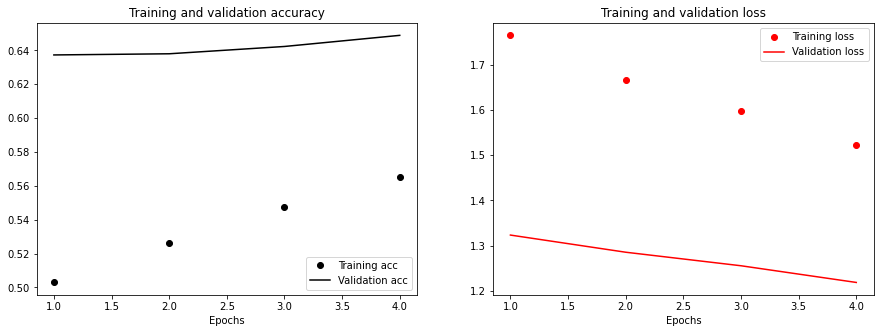

In [46]:
plot_results(history_vgg16)

### Transfer Learning with EfficientNet + Fine-Tuning

In [49]:
tf.keras.backend.clear_session()

#### Train only top layer

In [93]:
effnetb0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(target_size, target_size, 3))

effnetb0.trainable = False

model_effb0 = models.Sequential()

model_effb0.add(effnetb0)
model_effb0.add(layers.Flatten())
model_effb0.add(layers.Dense(256, activation="relu"))
model_effb0.add(layers.Dropout(0.6))
model_effb0.add(layers.Dense(num_classes, activation='softmax'))

model_effb0.summary()

model_effb0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten_3 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               20971776  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 26)                6682      
Total params: 25,028,029
Trainable params: 20,978,458
Non-trainable params: 4,049,571
_________________________________________________________________


In [51]:
%%time

filepath_eff = save_dir + "/model_effb0.hdf5"
checkpoint_eff = ModelCheckpoint(filepath_eff, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_effb0 = model_effb0.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_eff]
)

Epoch 1/4
637/637 [==============================] - 1747s 3s/step - loss: 2.2952 - accuracy: 0.4573 - val_loss: 1.2088 - val_accuracy: 0.6345

Epoch 00001: val_accuracy improved from -inf to 0.63453, saving model to ./savefiles/model_effb0.hdf5
Epoch 2/4
637/637 [==============================] - 1938s 3s/step - loss: 1.7165 - accuracy: 0.5267 - val_loss: 1.1209 - val_accuracy: 0.6396

Epoch 00002: val_accuracy improved from 0.63453 to 0.63962, saving model to ./savefiles/model_effb0.hdf5
Epoch 3/4
637/637 [==============================] - 1610s 3s/step - loss: 1.5669 - accuracy: 0.5508 - val_loss: 1.0995 - val_accuracy: 0.6451

Epoch 00003: val_accuracy improved from 0.63962 to 0.64511, saving model to ./savefiles/model_effb0.hdf5
Epoch 4/4
637/637 [==============================] - 1819s 3s/step - loss: 1.5004 - accuracy: 0.5657 - val_loss: 1.0475 - val_accuracy: 0.6725

Epoch 00004: val_accuracy improved from 0.64511 to 0.67255, saving model to ./savefiles/model_effb0.hdf5
CPU tim

In [79]:
model_effb0.load_weights(filepath_eff)

model_effb0.save(save_dir + '/effb0.h5')

with open(save_dir + '/effb0_hist.pickle', 'wb') as handle:
    pickle.dump(history_effb0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Unfreeze part of base model and retrain

In [101]:
effnetb0.trainable = True

for layer in effnetb0.layers[:-20]:
    layer.trainable = False
for layer in effnetb0.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_effb0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_effb0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               20971776  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 25,028,029
Trainable params: 22,329,418
Non-trainable params: 2,698,611
_________________________________________________________________


In [103]:
%%time

history_effb0 = model_effb0.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_eff]
)

Epoch 1/4
637/637 [==============================] - 1142s 2s/step - loss: 1.5856 - accuracy: 0.5432 - val_loss: 1.0753 - val_accuracy: 0.6478

Epoch 00001: val_accuracy improved from -inf to 0.64776, saving model to ./savefiles/model_effb0.hdf5
Epoch 2/4
637/637 [==============================] - 1117s 2s/step - loss: 1.4995 - accuracy: 0.5636 - val_loss: 1.0008 - val_accuracy: 0.6745

Epoch 00002: val_accuracy improved from 0.64776 to 0.67451, saving model to ./savefiles/model_effb0.hdf5
Epoch 3/4
637/637 [==============================] - 1087s 2s/step - loss: 1.4593 - accuracy: 0.5733 - val_loss: 0.9910 - val_accuracy: 0.6918

Epoch 00003: val_accuracy improved from 0.67451 to 0.69185, saving model to ./savefiles/model_effb0.hdf5
Epoch 4/4
637/637 [==============================] - 1100s 2s/step - loss: 1.4314 - accuracy: 0.5797 - val_loss: 0.9713 - val_accuracy: 0.6996

Epoch 00004: val_accuracy improved from 0.69185 to 0.69959, saving model to ./savefiles/model_effb0.hdf5
CPU tim

In [105]:
model_effb0.load_weights(filepath_eff)

model_effb0.save(save_dir + '/effb0_ft.h5')

with open(save_dir + '/effb0_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_effb0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

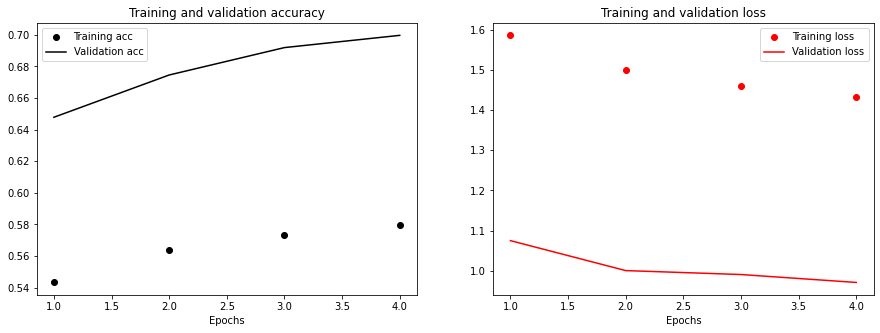

In [106]:
plot_results(history_effb0)

### CoAtNet + Fine-Tuning

In [53]:
# !pip install -U keras-cv-attention-models
import keras_cv_attention_models

#### Adjust model inputs to match CoAtNet weights

In [54]:
alt_target_size = 224

alt_train_gen = (
    train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=target_col,
                        color_mode='rgb',
                        target_size=(alt_target_size, alt_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

alt_val_gen = (
    val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=target_col,
                        target_size=(alt_target_size, alt_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 26 classes.
Found 10206 validated image filenames belonging to 26 classes.


#### Train top layer

In [55]:
tf.keras.backend.clear_session()

In [56]:
coatnet0 = keras_cv_attention_models.coatnet.CoAtNet0(
    num_classes=0,
    input_shape=(alt_target_size, alt_target_size, 3))

coatnet0.trainable = False

model_coat0 = models.Sequential()

model_coat0.add(coatnet0)
model_coat0.add(layers.Flatten())
model_coat0.add(layers.Dense(256, activation="relu"))
model_coat0.add(layers.Dropout(0.6))
model_coat0.add(layers.Dense(num_classes, activation='softmax'))

model_coat0.summary()

model_coat0.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/coatnet0_224_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 9,640,730
Non-trainable params: 23,075,178
_________________________________________________________________


In [57]:
%%time

filepath_coat = save_dir + "/model_coat0.hdf5"
checkpoint_coat = ModelCheckpoint(filepath_coat, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_coat0 = model_coat0.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_coat]
)

Epoch 1/4
637/637 [==============================] - 1536s 2s/step - loss: 2.1955 - accuracy: 0.4557 - val_loss: 1.2045 - val_accuracy: 0.6204

Epoch 00001: val_accuracy improved from -inf to 0.62042, saving model to ./savefiles/model_coat0.hdf5
Epoch 2/4
637/637 [==============================] - 1521s 2s/step - loss: 1.7330 - accuracy: 0.5098 - val_loss: 1.1471 - val_accuracy: 0.6239

Epoch 00002: val_accuracy improved from 0.62042 to 0.62395, saving model to ./savefiles/model_coat0.hdf5
Epoch 3/4
637/637 [==============================] - 1524s 2s/step - loss: 1.6252 - accuracy: 0.5244 - val_loss: 1.0837 - val_accuracy: 0.6318

Epoch 00003: val_accuracy improved from 0.62395 to 0.63179, saving model to ./savefiles/model_coat0.hdf5
Epoch 4/4
637/637 [==============================] - 1531s 2s/step - loss: 1.5472 - accuracy: 0.5337 - val_loss: 1.0859 - val_accuracy: 0.6228

Epoch 00004: val_accuracy did not improve from 0.63179
CPU times: user 1h 35min 48s, sys: 5min 23s, total: 1h 41

In [58]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0.h5')

with open(save_dir + '/coat0_hist.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Unfreeze part of base model and retrain

In [120]:
coatnet0.trainable = True


for layer in coatnet0.layers[:-7]:
    layer.trainable = False
for layer in coatnet0.layers[-7:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
model_coat0.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_coat0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coatnet0 (Functional)        (None, 7, 7, 768)         23075178  
_________________________________________________________________
flatten (Flatten)            (None, 37632)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               9634048   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 32,715,908
Trainable params: 14,950,682
Non-trainable params: 17,765,226
_________________________________________________________________


In [121]:
%%time


history_coat0 = model_coat0.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_coat]
)

Epoch 1/4
637/637 [==============================] - 923s 1s/step - loss: 1.5093 - accuracy: 0.5453 - val_loss: 1.0558 - val_accuracy: 0.6326

Epoch 00001: val_accuracy improved from -inf to 0.63257, saving model to ./savefiles/model_coat0.hdf5
Epoch 2/4
637/637 [==============================] - 1046s 2s/step - loss: 1.4796 - accuracy: 0.5513 - val_loss: 1.0388 - val_accuracy: 0.6374

Epoch 00002: val_accuracy improved from 0.63257 to 0.63737, saving model to ./savefiles/model_coat0.hdf5
Epoch 3/4
637/637 [==============================] - 940s 1s/step - loss: 1.4521 - accuracy: 0.5565 - val_loss: 1.0402 - val_accuracy: 0.6365

Epoch 00003: val_accuracy did not improve from 0.63737
Epoch 4/4
637/637 [==============================] - 889s 1s/step - loss: 1.4314 - accuracy: 0.5630 - val_loss: 1.0313 - val_accuracy: 0.6406

Epoch 00004: val_accuracy improved from 0.63737 to 0.64060, saving model to ./savefiles/model_coat0.hdf5
CPU times: user 59min 26s, sys: 4min 17s, total: 1h 3min 43s

In [122]:
model_coat0.load_weights(filepath_coat)

model_coat0.save(save_dir + '/coat0_ft.h5')

with open(save_dir + '/coat0_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_coat0.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
plot_results(history_coat0)

### LeViT + Fine-Tuning

In [59]:
tf.keras.backend.clear_session()

#### Train top layer

In [60]:
levit192 = keras_cv_attention_models.levit.LeViT128(
    num_classes=0,
    input_shape=(alt_target_size, alt_target_size, 3))

levit192.trainable = False

model_levit = models.Sequential()

model_levit.add(levit192)
model_levit.add(layers.Flatten())
model_levit.add(layers.Dense(256, activation="relu"))
model_levit.add(layers.Dropout(0.6))
model_levit.add(layers.Dense(num_classes, activation='softmax'))

model_levit.summary()

model_levit.compile(loss='categorical_crossentropy',
                   optimizer="adam",
                   metrics=['accuracy'])

>>>> Load pretrained from: /home/msds2022/nlapid/.keras/models/levit128_imagenet.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 1,579,802
Non-trainable params: 8,489,472
_________________________________________________________________


In [61]:
%%time

filepath_lev = save_dir + "/model_levit.hdf5"
checkpoint_lev = ModelCheckpoint(filepath_lev, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_levit = model_levit.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_lev]
)

Epoch 1/4
637/637 [==============================] - 1311s 2s/step - loss: 2.1482 - accuracy: 0.4920 - val_loss: 1.1756 - val_accuracy: 0.6484

Epoch 00001: val_accuracy improved from -inf to 0.64844, saving model to ./savefiles/model_levit.hdf5
Epoch 2/4
637/637 [==============================] - 830s 1s/step - loss: 1.5523 - accuracy: 0.5725 - val_loss: 1.0507 - val_accuracy: 0.6656

Epoch 00002: val_accuracy improved from 0.64844 to 0.66559, saving model to ./savefiles/model_levit.hdf5
Epoch 3/4
637/637 [==============================] - 863s 1s/step - loss: 1.3950 - accuracy: 0.6067 - val_loss: 0.9770 - val_accuracy: 0.6977

Epoch 00003: val_accuracy improved from 0.66559 to 0.69773, saving model to ./savefiles/model_levit.hdf5
Epoch 4/4
637/637 [==============================] - 847s 1s/step - loss: 1.3329 - accuracy: 0.6159 - val_loss: 0.9202 - val_accuracy: 0.7052

Epoch 00004: val_accuracy improved from 0.69773 to 0.70517, saving model to ./savefiles/model_levit.hdf5
CPU times:

In [62]:
model_levit.load_weights(filepath_lev)

model_levit.save(save_dir + '/levit.h5')

with open(save_dir + '/levit_hist.pickle', 'wb') as handle:
    pickle.dump(history_levit.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Unfreeze part of base model and retrain

In [115]:
levit192.trainable = True

for layer in levit192.layers[:-8]:
    layer.trainable = False
for layer in levit192.layers[-8:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_levit.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=1e-5),
                    metrics=['accuracy'])

model_levit.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
levit128 (Functional)        (None, 16, 384)           8489472   
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1573120   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6682      
Total params: 10,069,274
Trainable params: 2,171,930
Non-trainable params: 7,897,344
_________________________________________________________________


In [117]:
%%time


history_levit = model_levit.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_lev]
)

Epoch 1/4
637/637 [==============================] - 935s 1s/step - loss: 1.3234 - accuracy: 0.6242 - val_loss: 0.9673 - val_accuracy: 0.6886

Epoch 00001: val_accuracy did not improve from 0.70517
Epoch 2/4
637/637 [==============================] - 906s 1s/step - loss: 1.2779 - accuracy: 0.6337 - val_loss: 0.9448 - val_accuracy: 0.6965

Epoch 00002: val_accuracy did not improve from 0.70517
Epoch 3/4
637/637 [==============================] - 1403s 2s/step - loss: 1.2498 - accuracy: 0.6394 - val_loss: 0.9280 - val_accuracy: 0.7026

Epoch 00003: val_accuracy did not improve from 0.70517
Epoch 4/4
637/637 [==============================] - 978s 2s/step - loss: 1.2323 - accuracy: 0.6419 - val_loss: 0.9064 - val_accuracy: 0.7094

Epoch 00004: val_accuracy improved from 0.70517 to 0.70939, saving model to ./savefiles/model_levit.hdf5
CPU times: user 1h 55s, sys: 4min 15s, total: 1h 5min 10s
Wall time: 1h 10min 23s


In [118]:
model_levit.load_weights(filepath_lev)

model_levit.save(save_dir + '/levit_ft.h5')

with open(save_dir + '/levit_hist_ft.pickle', 'wb') as handle:
    pickle.dump(history_levit.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

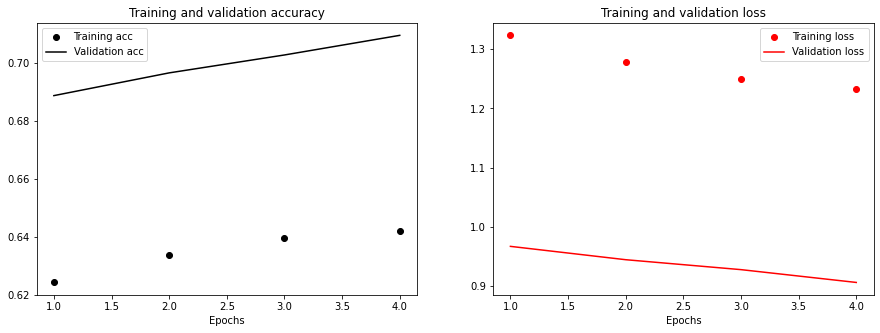

In [119]:
plot_results(history_levit)

### Inception V3

In [123]:
more_epochs = 10

In [124]:
tf.keras.backend.clear_session()

#### Training

In [125]:
inception_v3_base = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = "imagenet")

for layer in inception_v3_base.layers[:249]:
    layer.trainable = False
for layer in inception_v3_base.layers[249:]:
    layer.trainable = True


model_inv3_main = models.Sequential()
model_inv3_main.add(layers.Lambda(preprocess_inception_v3,
                             input_shape=(target_size, target_size, 3)))
model_inv3_main.add(inception_v3_base)
model_inv3_main.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3_main.add(layers.Flatten())
model_inv3_main.add(layers.Dense(256, activation="relu"))
model_inv3_main.add(layers.Dropout(0.6))
model_inv3_main.add(layers.Dense(num_classes, activation='softmax'))

model_inv3_main.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                6

In [126]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_inv3_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [128]:
%%time

filepath_inv3b = save_dir + "/inv3_main_wts.hdf5"
checkpoint_inv3b = ModelCheckpoint(filepath_inv3b, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop_inv3b = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr_inv3b = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

history_inv3_main = model_inv3_main.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3b, earlystop_inv3b, reduce_lr_inv3b]
)

Epoch 1/10
637/637 [==============================] - 1083s 2s/step - loss: 1.3080 - accuracy: 0.6628 - top_5_acc: 0.8821 - top_5_map: 0.1764 - val_loss: 0.6702 - val_accuracy: 0.8184 - val_top_5_acc: 0.9615 - val_top_5_map: 0.1923

Epoch 00001: val_accuracy improved from -inf to 0.81844, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 2/10
637/637 [==============================] - 1011s 2s/step - loss: 0.7614 - accuracy: 0.7882 - top_5_acc: 0.9516 - top_5_map: 0.1903 - val_loss: 0.5088 - val_accuracy: 0.8587 - val_top_5_acc: 0.9756 - val_top_5_map: 0.1951

Epoch 00002: val_accuracy improved from 0.81844 to 0.85871, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 3/10
637/637 [==============================] - 1007s 2s/step - loss: 0.6358 - accuracy: 0.8212 - top_5_acc: 0.9646 - top_5_map: 0.1929 - val_loss: 0.4205 - val_accuracy: 0.8768 - val_top_5_acc: 0.9816 - val_top_5_map: 0.1963

Epoch 00003: val_accuracy improved from 0.85871 to 0.87684, saving model to ./savefiles/in

In [130]:
model_inv3_main.load_weights(filepath_inv3b)

model_inv3_main.save(save_dir + '/inv3_main.h5')

with open(save_dir + '/inv3_hist_main.pickle', 'wb') as handle:
    pickle.dump(history_inv3_main.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [146]:
def plot_results_v2(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax[0, 0].plot(epochs, acc, 'ko', label='Training Accuracy')
    ax[0, 0].plot(epochs, val_acc, 'k', label='Validation Accuracy')
    ax[0, 0].set_title('Training and Validation Categorical Accuracy')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].legend()

    # plot Top-5 Accuracy
    top_5_acc = history.history['top_5_acc']
    val_top_5_acc = history.history['val_top_5_acc']

    ax[1, 0].plot(epochs, top_5_acc, 'ko', label='Training Top-5 Accuracy')
    ax[1, 0].plot(epochs, val_top_5_acc, 'k', label='Validation Top-5 Accuracy')
    ax[1, 0].set_title('Training and Validation Top-5 Accuracy')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].legend()

    # plot Top-5 MAP
    top_5_map = history.history['top_5_map']
    val_top_5_map = history.history['val_top_5_map']

    ax[0, 1].plot(epochs, top_5_map, 'ko', label="Training Top-5 MAP")
    ax[0, 1].plot(epochs, val_top_5_map, 'k', label="Validation Top-5 MAP")
    ax[0, 1].set_title("Training and Validation Top-5 MAP")
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax[1, 1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1, 1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1, 1].set_title('Training and Validation Categorical Cross-Entropy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].legend()

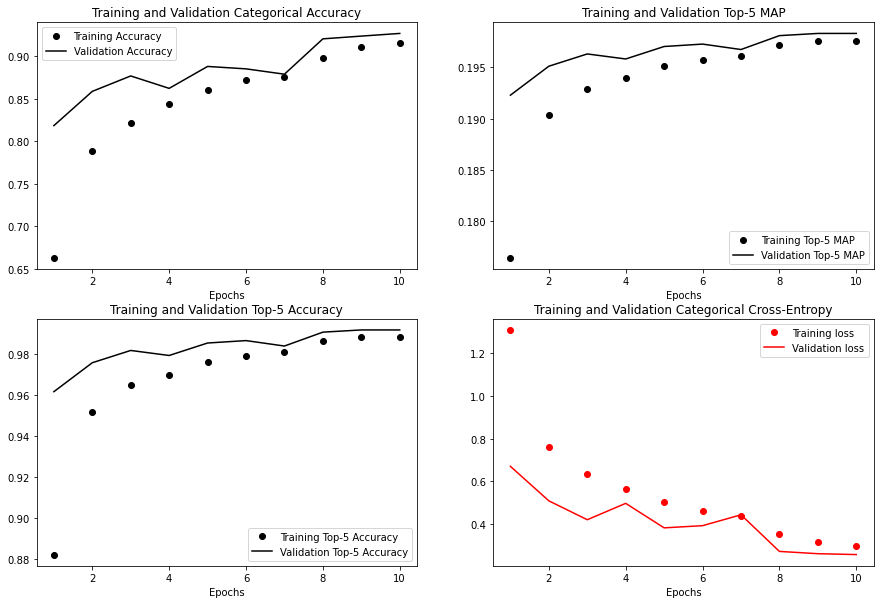

In [150]:
plot_results_v2(history_inv3_main)

#### Fine-tuning

In [135]:
model_inv3_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(learning_rate=1e-4),
                         metrics=metrics)

In [136]:
%%time

reduce_lr_inv3b = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)


history_inv3_main_ft = model_inv3_main.fit(
    unscaled_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=unscaled_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3b, earlystop_inv3b, reduce_lr_inv3b]
)

Epoch 1/10
637/637 [==============================] - 984s 2s/step - loss: 0.2737 - accuracy: 0.9226 - top_5_acc: 0.9905 - top_5_map: 0.1981 - val_loss: 0.2538 - val_accuracy: 0.9319 - val_top_5_acc: 0.9929 - val_top_5_map: 0.1986

Epoch 00001: val_accuracy improved from 0.92681 to 0.93190, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 2/10
637/637 [==============================] - 928s 1s/step - loss: 0.2686 - accuracy: 0.9234 - top_5_acc: 0.9901 - top_5_map: 0.1980 - val_loss: 0.2337 - val_accuracy: 0.9334 - val_top_5_acc: 0.9928 - val_top_5_map: 0.1986

Epoch 00002: val_accuracy improved from 0.93190 to 0.93337, saving model to ./savefiles/inv3_main_wts.hdf5
Epoch 3/10
637/637 [==============================] - 952s 1s/step - loss: 0.2591 - accuracy: 0.9255 - top_5_acc: 0.9909 - top_5_map: 0.1982 - val_loss: 0.2282 - val_accuracy: 0.9334 - val_top_5_acc: 0.9937 - val_top_5_map: 0.1987

Epoch 00003: val_accuracy did not improve from 0.93337
Epoch 4/10
637/637 [===============

In [137]:
model_inv3_main.load_weights(filepath_inv3b)

model_inv3_main.save(save_dir + '/inv3_main_ft.h5')

with open(save_dir + '/inv3_hist_main_ft.pickle', 'wb') as handle:
    pickle.dump(history_inv3_main_ft.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

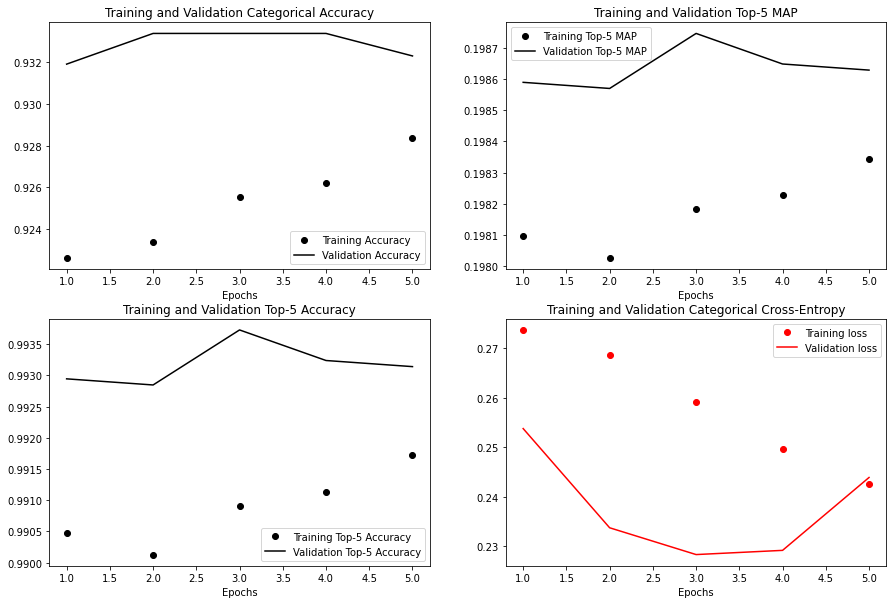

In [153]:
plot_results_v2(history_inv3_main_ft)

### EfficientNet Individual Identification

Based on https://www.kaggle.com/jasonczh/pretrained-model-with-keras/notebook

In [120]:
label_col = "individual_id"
num_label = len(df_train[label_col].value_counts())

batch_size = 128
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size

more_epochs = 10
label_target_size = 32

In [121]:
# Training set
label_train_datagen = ImageDataGenerator(validation_split=0.2,
                                         preprocessing_function=None,
                                         rotation_range=45,
                                         zoom_range=0.2,
                                         brightness_range=[0.6, 1.4],
                                         channel_shift_range=0.7,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest',
                                         shear_range=0.1,
                                         height_shift_range=0.1,
                                         width_shift_range=0.1)

label_train_gen = (
    label_train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=label_col,
                        color_mode='rgb',
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
label_val_datagen = ImageDataGenerator(validation_split=0.2)

label_val_gen = (
    label_val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=label_col,
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 15587 classes.
Found 10206 validated image filenames belonging to 15587 classes.


In [122]:
tf.keras.backend.clear_session()
gc.collect()

base_model = tf.keras.applications.EfficientNetB0(
               input_shape=(label_target_size, label_target_size, 3), 
               weights=None,
               include_top=False)

base_model.trainable = False

layer = base_model.output
layer = layers.Dense(256, activation='relu')(layer)
layer = layers.Flatten()(layer)
predictions = layers.Dense(num_label, activation='softmax')(layer)
model_effb0 = models.Model(inputs=base_model.input, outputs=predictions)

model_effb0.compile(loss='categorical_crossentropy',
                    optimizer="adam",
                    metrics=['accuracy'])

model_effb0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 32, 32, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 33, 33, 3)    0           normalization[0][0]              
______________________________________________________________________________________________

In [113]:
# tf.keras.backend.clear_session()


# effnetb0 = tf.keras.applications.EfficientNetB0(
#     include_top=False,
#     weights=None,
#     input_shape=(label_target_size, label_target_size, 3))

# # effnetb0.trainable = False

# model_effb0 = models.Sequential()

# model_effb0.add(effnetb0)

# # model_effb0.add(layers.Flatten())
# model_effb0.add(layers.Dense(1024, activation="relu"))
# # model_effb0.add(layers.Dropout(0.6))
# model_effb0.add(layers.Dense(num_classes, activation='softmax'))

# model_effb0.summary()

# model_effb0.compile(loss='categorical_crossentropy',
#                    optimizer="adam",
#                    metrics=['accuracy'])

In [124]:
%%time

filepath_eff = save_dir + "/model_effb0_label.hdf5"
checkpoint_eff = ModelCheckpoint(filepath_eff, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')

history_effb0 = model_effb0.fit(
    label_train_gen,
#     steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=label_val_gen,
#     validation_steps=validation_steps,
    callbacks=[checkpoint_eff]
)

Epoch 1/10
  2/319 [..............................] - ETA: 10:42 - loss: 9.3604 - accuracy: 0.0039    

KeyboardInterrupt: 

### Inception V3 Individual Identification

In [80]:
label_col = "individual_id"
num_label = len(df_train[label_col].value_counts())

batch_size = 128
steps_per_epoch = len(df_train) * 0.8 / batch_size
validation_steps = len(df_train) * 0.2 / batch_size

more_epochs = 10
label_target_size = 112

In [81]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
tf.keras.backend.clear_session()

# Training set
label_train_datagen = ImageDataGenerator(validation_split=0.2,
                                         preprocessing_function=preprocess_inception_v3,
                                         rotation_range=45,
                                         zoom_range=0.2,
                                         brightness_range=[0.6, 1.4],
                                         channel_shift_range=0.7,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest',
                                         shear_range=0.1,
                                         height_shift_range=0.1,
                                         width_shift_range=0.1)

label_train_gen = (
    label_train_datagen.
    flow_from_dataframe(df_train,
                        directory = os.path.join(work_dir, train_folder),
                        subset="training",
                        x_col=img_col,
                        y_col=label_col,
                        color_mode='rgb',
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

# Validation set
label_val_datagen = ImageDataGenerator(validation_split=0.2)

label_val_gen = (
    label_val_datagen.
    flow_from_dataframe(df_train,
                        directory=os.path.join(work_dir, train_folder),
                        subset="validation",
                        color_mode='rgb',
                        x_col=img_col,
                        y_col=label_col,
                        target_size=(label_target_size, label_target_size),
                        batch_size=batch_size,
                        class_mode="categorical")
)

Found 40827 validated image filenames belonging to 15587 classes.
Found 10206 validated image filenames belonging to 15587 classes.


#### Training

In [82]:
inception_v3_label = tf.keras.applications.InceptionV3(
    include_top=False,
    weights = None,
    input_shape=(label_target_size, label_target_size, 3))

# for layer in inception_v3_label.layers[:249]:
#     layer.trainable = False
# for layer in inception_v3_label.layers[249:]:
#     layer.trainable = True


model_inv3_label = models.Sequential()
# model_inv3_label.add(layers.Lambda(preprocess_inception_v3,
#                              input_shape=(label_target_size,
#                                           label_target_size, 3)))
model_inv3_label.add(inception_v3_label)
model_inv3_label.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_inv3_label.add(layers.Flatten())
model_inv3_label.add(layers.Dense(512, activation="relu"))
model_inv3_label.add(layers.Dropout(0.5))
model_inv3_label.add(layers.Dense(num_label, activation='softmax'))

model_inv3_label.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15587)             7996131   
Total params: 30,848,003
Trainable params: 30,813,571
Non-trainable params: 34,432
_______________________________________

In [83]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_inv3_label.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [84]:
%%time

filepath_inv3_label = save_dir + "/inv3_label_wts_v2.hdf5"
checkpoint_inv3_label = ModelCheckpoint(filepath_inv3_label,
                                        monitor='val_accuracy',
                                        verbose=1, save_best_only=True,
                                        mode='max')
earlystop_inv3_label = EarlyStopping(monitor='val_accuracy',
                                     patience=3, verbose=1)
reduce_lr_inv3_label = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                         patience=2, min_lr=0.00001,
                                         verbose=1)

history_inv3_label = model_inv3_label.fit(
    label_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=label_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_inv3_label, earlystop_inv3_label,
               reduce_lr_inv3_label]
)

Epoch 1/10
 10/318 [..............................] - ETA: 16:17 - loss: 9.6990 - accuracy: 0.0031 - top_5_acc: 0.0047 - top_5_map: 9.3750e-04   

KeyboardInterrupt: 

In [148]:
model_inv3_label.load_weights(filepath_inv3_label)

model_inv3_label.save(save_dir + '/inv3_label_v2.h5')

with open(save_dir + '/inv3_hist_label_v2.pickle', 'wb') as handle:
    pickle.dump(history_inv3_label.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

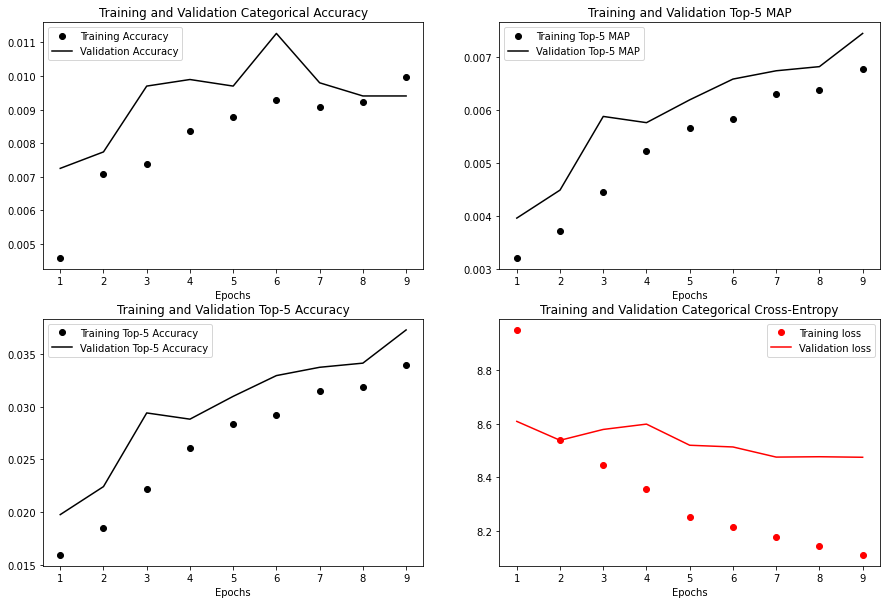

In [149]:
plot_results_v2(history_inv3_label)

### Predicting on the Test Set and Preparing a Submission

In [98]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

model_inv3_label = tf.keras.models.load_model(save_dir + '/inv3_label.h5')

In [99]:
label_target_size = 384

test = os.listdir("./jpeg-happywhale-384x384/test_images")
print(len(test))

27956


In [100]:
df_test = pd.DataFrame(test, columns=['image'])
df_test['predictions'] = ''

In [101]:
def Loading_Images(data, num, dataset):
#     print("Loading images")
    X_train = np.zeros((num, label_target_size, label_target_size, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("./jpeg-happywhale-384x384/" + dataset + "/" + fig,
                             target_size=(label_target_size, label_target_size, 3))
        x = image.img_to_array(img)
        x = preprocess_inception_v3(x)
        X_train[count] = x
        count += 1
    return X_train


def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [102]:
y, label_encoder = prepare_labels(df_train['individual_id'])

In [31]:
batch_size = 1000
batch_start = 0
batch_end = batch_size
len_df = len(df_test)


while batch_start < len_df:
    limit = min(batch_end, len_df)
    df_test_batch = df_test.iloc[batch_start:limit]
    X = Loading_Images(df_test_batch, df_test_batch.shape[0], "test_images")
    X /= 255
    predictions = model_inv3_label.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p = pred.argsort()[-5:][::-1]
        idx = -1
        s = ''
        s1 = ''
        s2 = ''
        for x in p:
            idx = idx + 1
            if pred[x] > 0.1:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s = s1 + ' new_individual' + s2
        s = s.strip(' ')
        df_test.loc[batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    print(f'Processed {limit}')
    del X
    del df_test_batch
    del predictions
    gc.collect()

100%|██████████| 1000/1000 [00:07<00:00, 127.43it/s]


32/32 [==============================] - 4s 99ms/step
Processed 1000


100%|██████████| 1000/1000 [00:07<00:00, 129.38it/s]


32/32 [==============================] - 4s 100ms/step
Processed 2000


100%|██████████| 1000/1000 [00:07<00:00, 126.76it/s]


32/32 [==============================] - 4s 99ms/step
Processed 3000


100%|██████████| 1000/1000 [00:08<00:00, 123.56it/s]


32/32 [==============================] - 4s 100ms/step
Processed 4000


100%|██████████| 1000/1000 [00:07<00:00, 130.90it/s]


32/32 [==============================] - 4s 100ms/step
Processed 5000


100%|██████████| 1000/1000 [00:07<00:00, 131.92it/s]


32/32 [==============================] - 4s 99ms/step
Processed 6000


100%|██████████| 1000/1000 [00:07<00:00, 129.41it/s]


32/32 [==============================] - 4s 100ms/step
Processed 7000


100%|██████████| 1000/1000 [00:07<00:00, 131.03it/s]


32/32 [==============================] - 4s 99ms/step
Processed 8000


100%|██████████| 1000/1000 [00:07<00:00, 126.24it/s]


32/32 [==============================] - 4s 98ms/step
Processed 9000


100%|██████████| 1000/1000 [00:07<00:00, 125.48it/s]


32/32 [==============================] - 4s 99ms/step
Processed 10000


100%|██████████| 1000/1000 [00:07<00:00, 129.20it/s]


32/32 [==============================] - 4s 98ms/step
Processed 11000


100%|██████████| 1000/1000 [00:07<00:00, 131.06it/s]


32/32 [==============================] - 4s 99ms/step
Processed 12000


100%|██████████| 1000/1000 [00:07<00:00, 131.19it/s]


32/32 [==============================] - 4s 99ms/step
Processed 13000


100%|██████████| 1000/1000 [00:07<00:00, 131.20it/s]


32/32 [==============================] - 4s 99ms/step
Processed 14000


100%|██████████| 1000/1000 [00:07<00:00, 129.65it/s]


32/32 [==============================] - 4s 100ms/step
Processed 15000


100%|██████████| 1000/1000 [00:07<00:00, 126.91it/s]


32/32 [==============================] - 4s 99ms/step
Processed 16000


100%|██████████| 1000/1000 [00:07<00:00, 130.69it/s]


32/32 [==============================] - 4s 100ms/step
Processed 17000


100%|██████████| 1000/1000 [00:07<00:00, 129.00it/s]


32/32 [==============================] - 4s 100ms/step
Processed 18000


100%|██████████| 1000/1000 [00:07<00:00, 128.32it/s]


32/32 [==============================] - 4s 100ms/step
Processed 19000


100%|██████████| 1000/1000 [00:07<00:00, 128.30it/s]


32/32 [==============================] - 4s 100ms/step
Processed 20000


100%|██████████| 1000/1000 [00:07<00:00, 127.61it/s]


32/32 [==============================] - 4s 99ms/step
Processed 21000


100%|██████████| 1000/1000 [00:07<00:00, 125.78it/s]


32/32 [==============================] - 4s 101ms/step
Processed 22000


100%|██████████| 1000/1000 [00:07<00:00, 125.83it/s]


32/32 [==============================] - 4s 100ms/step
Processed 23000


100%|██████████| 1000/1000 [00:07<00:00, 128.75it/s]


32/32 [==============================] - 4s 100ms/step
Processed 24000


100%|██████████| 1000/1000 [00:08<00:00, 121.43it/s]


32/32 [==============================] - 4s 101ms/step
Processed 25000


100%|██████████| 1000/1000 [00:08<00:00, 120.08it/s]


32/32 [==============================] - 4s 99ms/step
Processed 26000


100%|██████████| 1000/1000 [00:07<00:00, 129.42it/s]


32/32 [==============================] - 4s 100ms/step
Processed 27000


100%|██████████| 956/956 [00:07<00:00, 124.86it/s]


30/30 [==============================] - 4s 99ms/step
Processed 27956


In [32]:
df_test.to_csv('submission2.csv', index=False)
df_test

,image,predictions
0,0453ad477acaec.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
1,0454ac14150afc.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
2,055b5053dab2f1.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
3,068bd9a7665887.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
4,078c471d482d92.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
...,...,...
27951,8be7efa92a4fc5.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27952,a3fbacc98667b1.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27953,345c5689d879b2.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
27954,fe0681ef62e5ed.jpg,37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...


In [36]:
df_test['predictions'][10000:11000]

10000    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10001    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10002    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10003    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10004    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
                               ...                        
10995    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10996    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10997    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10998    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
10999    37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e9...
Name: predictions, Length: 1000, dtype: object

In [27]:
df_test['predictions'].tolist()

['37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_indiv

In [52]:
df_test['predictions'].tolist()

['37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_individual',
 '37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c new_indiv

In [35]:
df_test['predictions'].tolist()

['new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e0c55c',
 'new_individual 37c7aba965a5 180c0ab04dcd abbeba14a290 938b7e931166 6a3af6e

## Tuning the CoAtNet Model

In [ ]:
more_epochs = 10

In [ ]:
tf.keras.backend.clear_session()

#### Training

In [ ]:
coatnet0_base = keras_cv_attention_models.coatnet.CoAtNet0(
    num_classes=0,    # to exclude top layers
    input_shape=(coat_target_size, coat_target_size, 3))

coatnet0_base.trainable = False

model_coat0_main = models.Sequential()

model_coat0_main.add(coatnet0_base)
model_coat0_main.add(layers.Flatten())
model_coat0_main.add(layers.Dense(256, activation="relu"))
model_coat0_main.add(layers.Dropout(0.6))
model_coat0_main.add(layers.Dense(num_classes, activation='softmax'))

model_coat0_main.summary()

In [ ]:
metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_coat0_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=metrics)

In [ ]:
%%time

filepath_coat2 = save_dir + "/coat_main_wts.hdf5"
checkpoint_coat2 = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop_coat2 = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr_coat2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

history_coat0_main = model_coat0_main.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint_coat2, earlystop_coat2, reduce_lr_coat2]
)

In [ ]:
model_coat0_main.load_weights(filepath)

model_coat0_main.save(save_dir + '/coat0_main.h5')

with open(save_dir + '/coat0_hist_main.pickle', 'wb') as handle:
    pickle.dump(history_coat0_main.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def plot_results_v2(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax[0, 0].plot(epochs, acc, 'ko', label='Training Accuracy')
    ax[0, 0].plot(epochs, val_acc, 'k', label='Validation Accuracy')
    ax[0, 0].set_title('Training and Validation Categorical Accuracy')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].legend()

    # plot Top-5 Accuracy
    top_5_acc = history.history['top_5_acc']
    val_top_5_acc = history.history['val_top_5_acc']

    ax[1, 0].plot(epochs, top_5_acc, 'ko', label='Training Top-5 Accuracy')
    ax[1, 0].plot(epochs, val_top_5_acc, 'k', label='Validation Top-5 Accuracy')
    ax[1, 0].set_title('Training and Validation Top-5 Accuracy')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].legend()

    # plot Top-5 MAP
    top_5_map = history.history['top_5_map']
    val_top_5_map = history.history['val_top_5_map']

    ax[0, 1].plot(epochs, top_5_map, 'ko', label="Training Top-5 MAP")
    ax[0, 1].plot(epochs, val_top_5_map, 'k', label="Validation Top-5 MAP")
    ax[0, 1].set_title("Training and Validation Cohen's Top-5 MAP")
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax[1, 1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1, 1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1, 1].set_title('Training and Validation Categorical Cross-Entropy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].legend()

In [ ]:
plot_results_v2(history_coat0_main)

#### Fine-tuning

In [ ]:
coatnet0_base.trainable = True

for layer in coatnet0_base.layers[:-7]:
    layer.trainable = False
for layer in coatnet0_base.layers[-7:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           tf.keras.metrics.TopKCategoricalAccuracy(5, name="top_5_acc"),
           tf.keras.metrics.Precision(top_k=5, name="top_5_map")]

model_coat0_main.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.Adam(learning_rate=1e-5),
                         metrics=metrics)

model_coat0_main.summary()

In [ ]:
%%time

filepath = save_dir + "/coat_main_wts.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)

history_coat0_main_ft = model_coat0_main.fit(
    alt_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=more_epochs,
    validation_data=alt_val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

In [ ]:
model_coat0_main.load_weights(filepath)

model_coat0_main.save(save_dir + '/coat0_main_ft.h5')

with open(save_dir + '/coat0_hist_main_ft.pickle', 'wb') as handle:
    pickle.dump(history_coat0_main_ft.history, handle,
                protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
plot_results_v2(history_coat0_main_ft)

### Changes to make:

1. preprocess input (https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)
2. change to label
3. add topkcategorical accuracy as a metric
4. lower learning rate when fine-tuning
5. use larger/original dataset
6. more loss metrics
7. checkpointing



In [ ]:
#     model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[
#             keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
#         ],
#     )